In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


### Mount the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My\ Drive/Colab\ Notebooks/NeuralODEs_ROM_Closure/neuralDDE_ROM_Closure

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/NeuralODEs_ROM_Closure/neuralDDE_ROM_Closure


### Load modules

In [3]:
from src.utilities.DDE_Solver import ddeinttf 
import src.advec_diff_case.advec_diff_eqn as adeq

import time
import sys
import os
from IPython.core.debugger import set_trace

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm

tf.keras.backend.set_floatx('float32')

## Define some useful classes

### Initial conditions

In [4]:
class initial_cond:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u0 = self.x / (1. + np.sqrt(1./self.app.t0) * np.exp(self.app.Re * self.x**2 / 4., dtype = np.float64))
        return tf.convert_to_tensor([u0], dtype=tf.float32)

### Analytical solution

In [5]:
class ad_eqn_analy:

    def __init__(self, x, app):
        self.x = x
        self.app = app

    def __call__(self, t):
        u = self.x/ (t + 1.) / (1. + np.sqrt((t + 1.)/self.app.t0, dtype = np.float64) * np.exp(self.app.Re * (self.x**2 / ((4. * t) + 4.)), dtype = np.float64))
        return tf.convert_to_tensor([u], dtype=tf.float32)

## Main part starts here

### User-defined parameters and create objects

In [6]:
app = adeq.ad_eqn_args(T = 2., nt = 200, L = 1., nx = 100, Re = 250, u_bc_0 = 0., u_bc_L =0., multi_solve_size = 1)

x = tf.linspace(0., app.L, app.nx)
u0 = initial_cond(x, app) # Initial conditions
t = tf.linspace(0., app.T, app.nt) # Time array

op = adeq.operators(app)

### Solve and plot

In [7]:
u = ddeinttf(adeq.ad_eqn(op), u0, t)

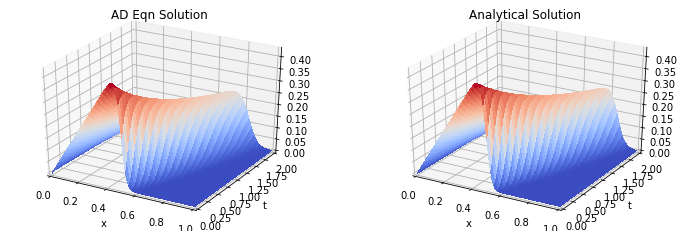

In [8]:
ad_eqn_ana_inst = ad_eqn_analy(x, app)

u_analy = []

for i in range(app.nt):
    u_analy.append(tf.expand_dims(ad_eqn_ana_inst(t[i]), axis = 1))

u_analy = tf.concat(u_analy, axis=0)

fig = plt.figure(figsize=(12, 4), facecolor='white')
ax_u = fig.add_subplot(121, projection='3d')
ax_u_analy = fig.add_subplot(122, projection='3d')

X, T = np.meshgrid(x.numpy(), t.numpy())

ax_u.cla()
ax_u.set_title('AD Eqn Solution')
ax_u.set_xlabel('x')
ax_u.set_ylabel('t')
ax_u.plot_surface(X, T, tf.squeeze(u, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u.set_xlim(x[0], x[-1])
ax_u.set_ylim(t[0], t[-1])

ax_u_analy.cla()
ax_u_analy.set_title('Analytical Solution')
ax_u_analy.set_xlabel('x')
ax_u_analy.set_ylabel('t')
ax_u_analy.plot_surface(X, T, tf.squeeze(u_analy, axis=1).numpy(), cmap=cm.coolwarm,
                    linewidth=0, antialiased=False)
ax_u_analy.set_xlim(x[0], x[-1])
ax_u_analy.set_ylim(t[0], t[-1])

fig.show()